In [471]:
import tensorflow as tf
import tensorflow_probability as tfp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn import mixture
from matplotlib.colors import LogNorm

matplotlib.rcParams['text.usetex'] = True

#### Autoencoder

In [71]:
data = pd.read_csv('data/clean_dataset.csv').set_index('original_index')
original_index = data.index

data = data.diff().ffill().dropna()

anomalies_list = np.array([10634, 36136, 57280, 57618, 60545, 63144, 118665, 128524, 131118])
anomalies = pd.DataFrame(np.ones(len(anomalies_list)), index=anomalies_list, columns=['Anomaly'])

In [84]:
TRAIN_SPLIT = 0.80
VALIDATION_SPLIT = 0.80
data_length = len(data)

train_ix = int(data_length*TRAIN_SPLIT)
val_ix = int(train_ix*VALIDATION_SPLIT)

X_train = data[:val_ix].values
X_test = data[train_ix:].values
X_val = data[val_ix:train_ix].values

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X_train = pd.DataFrame(X_train, index=original_index[:val_ix])
X_train = X_train.drop([10634, 36136, 57280, 57618, 60545, 63144])
X_train = X_train.values

In [86]:
LATENT_SIZE = 64
HIDDEN_SIZE = 128
FEATURE_NO = X_train.shape[1]

encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.Dense(FEATURE_NO, input_shape=(FEATURE_NO, ), activation='relu'))
encoder.add(tf.keras.layers.Dense(HIDDEN_SIZE, activation='relu'))
encoder.add(tf.keras.layers.Dense(LATENT_SIZE, activation='linear'))

decoder = tf.keras.Sequential()
decoder.add(tf.keras.layers.Dense(LATENT_SIZE, input_shape=(LATENT_SIZE, ), activation='relu'))
decoder.add(tf.keras.layers.Dense(HIDDEN_SIZE, activation='relu'))
decoder.add(tf.keras.layers.Dense(FEATURE_NO, activation='linear'))

autoencoder = tf.keras.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
autoencoder.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.MeanAbsoluteError())

In [87]:
EPOCHS = 100
BATCH_SIZE = 1024

autoencoder.fit(X_train, X_train, validation_data=(X_val, X_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

Train on 68287 samples, validate on 17074 samples
Epoch 1/100
68287/68287 [==============================] - 1s 10us/sample - loss: 0.2264 - val_loss: 0.2137
Epoch 2/100
68287/68287 [==============================] - 0s 6us/sample - loss: 0.2071 - val_loss: 0.2047
Epoch 3/100
68287/68287 [==============================] - 0s 6us/sample - loss: 0.2036 - val_loss: 0.2023
Epoch 4/100
68287/68287 [==============================] - 0s 6us/sample - loss: 0.1999 - val_loss: 0.1994
Epoch 5/100
68287/68287 [==============================] - 0s 6us/sample - loss: 0.1971 - val_loss: 0.1964
Epoch 6/100
68287/68287 [==============================] - 0s 6us/sample - loss: 0.1922 - val_loss: 0.1917
Epoch 7/100
68287/68287 [==============================] - 0s 6us/sample - loss: 0.1892 - val_loss: 0.1906
Epoch 8/100
68287/68287 [==============================] - 0s 6us/sample - loss: 0.1871 - val_loss: 0.1863
Epoch 9/100
68287/68287 [==============================] - 0s 6us/sample - loss: 0.1825 - val

In [93]:
X_pred = autoencoder.predict(X_test)
MSE = np.average((X_pred - X_test)**2, axis=1)

df_index = original_index[train_ix+1:]

result = pd.DataFrame(MSE, index=df_index, columns=['Error'])
result = result.join(anomalies).reset_index(drop=True)
anomalies_result = result.dropna()

annomalies = data.loc[anomalies_list]
annomalies = scaler.transform(annomalies)
annomalies_pred = autoencoder(annomalies)
annomalies_error = np.average((annomalies_pred - annomalies)**2, axis=1)

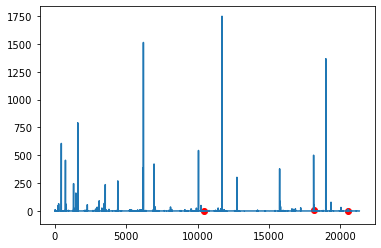

In [68]:
plt.plot(result.index, result.Error)
plt.scatter(anomalies_result.index, anomalies_result.Error, color='red')

#### Variational Autoencoder

In [100]:
data = pd.read_csv('data/clean_dataset.csv')
data = data.set_index('original_index')

In [101]:
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.8

anomalies_ix = np.array([10634, 36136, 57280, 57618, 60545, 63144, 118665, 128524, 131118])

data = data.diff().ffill().dropna()
annomaly_set = data.loc[anomalies_ix]

data = data.drop(anomalies_ix)
data_length = len(data)

TRAIN_VAL_IX = int(data_length*TRAIN_SPLIT)
VAL_IX = int(TRAIN_VAL_IX * VAL_SPLIT)

train_set = data[:VAL_IX]
val_set = data[VAL_IX:TRAIN_VAL_IX]
test_set = data[TRAIN_VAL_IX:]

train_ix = train_set.index
val_ix = val_set.index
test_ix = test_set.index

scaler = StandardScaler()

train_set = scaler.fit_transform(train_set)
val_set = scaler.transform(val_set)
test_set = scaler.transform(test_set)
annomaly_set = scaler.transform(annomaly_set)

In [102]:
LATENT_SIZE = 2
HIDDEN_SIZE0 = 256
HIDDEN_SIZE1 = 64
FEATURE_NO = train_set.shape[1]

tfd = tfp.distributions
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_SIZE), scale=1), reinterpreted_batch_ndims=1)

encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.Dense(HIDDEN_SIZE0, activation='relu', input_shape=(FEATURE_NO, )))
encoder.add(tf.keras.layers.Dense(HIDDEN_SIZE1, activation='relu'))
encoder.add(tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(LATENT_SIZE), activation=None))
encoder.add(tfp.layers.MultivariateNormalTriL(LATENT_SIZE, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior)))

decoder = tf.keras.Sequential()
decoder.add(tf.keras.layers.Dense(HIDDEN_SIZE1, activation='relu', input_shape=(LATENT_SIZE,)))
decoder.add(tf.keras.layers.Dense(HIDDEN_SIZE0, activation='relu'))
decoder.add(tf.keras.layers.Dense(FEATURE_NO*2, activation='linear'))
decoder.add(tfp.layers.DistributionLambda(lambda t : tfp.distributions.Normal(loc=t[...,:FEATURE_NO], scale=tf.math.softplus(t[...,FEATURE_NO:]))))

vae = tf.keras.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]))

negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
vae.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=negative_log_likelihood)

In [324]:
EPOCHS = 100
BATCH_SIZE = 1024

vae.fit(train_set, train_set, batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=True, validation_data=(train_set, train_set))

Train on 68288 samples, validate on 68288 samples
Epoch 1/100
68288/68288 [==============================] - 1s 11us/sample - loss: 0.2790 - val_loss: 0.2748
Epoch 2/100
68288/68288 [==============================] - 1s 11us/sample - loss: 0.2939 - val_loss: 0.2934
Epoch 3/100
68288/68288 [==============================] - 1s 10us/sample - loss: 0.2891 - val_loss: 0.2804
Epoch 4/100
68288/68288 [==============================] - 1s 10us/sample - loss: 0.2791 - val_loss: 0.2876
Epoch 5/100
68288/68288 [==============================] - 1s 10us/sample - loss: 0.2785 - val_loss: 0.2747
Epoch 6/100
68288/68288 [==============================] - 1s 10us/sample - loss: 0.2736 - val_loss: 0.2731
Epoch 7/100
68288/68288 [==============================] - 1s 10us/sample - loss: 0.2740 - val_loss: 0.2715
Epoch 8/100
68288/68288 [==============================] - 1s 10us/sample - loss: 0.2767 - val_loss: 0.2739
Epoch 9/100
68288/68288 [==============================] - 1s 10us/sample - loss: 0.27

In [398]:
train_encoded = encoder(train_set)
train_decoded = decoder(train_encoded)

val_encoded = encoder(val_set)
val_decoded = decoder(val_encoded)

annomaly_encoded = encoder(annomaly_set)
annomaly_decoded = decoder(annomaly_encoded)

test_encoded = encoder(test_set)
test_decoded = decoder(test_encoded)

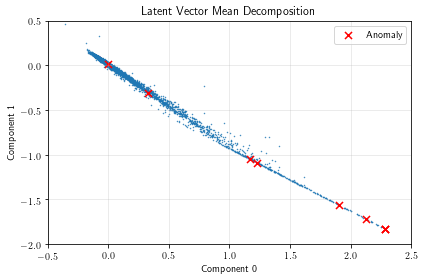

In [483]:
plt.scatter(test_encoded.mean()[:, 0], test_encoded.mean()[:, 1], s=0.2)
plt.scatter(annomaly_encoded.mean()[:, 0], annomaly_encoded.mean()[:, 1], s=50.0, color='red', marker='x', label='Anomaly')

plt.xlim(-0.5, 2.5)
plt.ylim(-2, 0.5)

plt.title('Latent Vector Mean Decomposition')
plt.xlabel('Component 0')
plt.ylabel('Component 1')

plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('decomposition.png', bbox_inches='tight')
plt.show()

In [498]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(train_encoded.mean())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [629]:
test_cdf = ((test_set - test_decoded.mean())/test_decoded.stddev()).numpy()
annomaly_cdf = ((annomaly_set - annomaly_decoded.mean())/annomaly_decoded.stddev()).numpy()

In [618]:
n = 3
COLUMN_MAP = {key: value for key, value in zip([i for i in range(len(data.columns.values))], data.columns.values)}

test_cdf_ix = pd.DataFrame((-test_cdf).argsort(axis=-1)[:, :n], index=test_ix, columns=['Rank1', 'Rank2', 'Rank3'])
annomaly_cdf_ix = pd.DataFrame((-annomaly_cdf).argsort(axis=-1)[:, :n], index=anomalies_ix, columns=['Rank1', 'Rank2', 'Rank3'])

test_cdf_ix['Rank1'] = test_cdf_ix['Rank1'].map(COLUMN_MAP)
test_cdf_ix['Rank2'] = test_cdf_ix['Rank2'].map(COLUMN_MAP)
test_cdf_ix['Rank3'] = test_cdf_ix['Rank3'].map(COLUMN_MAP)

annomaly_cdf_ix['Rank1'] = annomaly_cdf_ix['Rank1'].map(COLUMN_MAP)
annomaly_cdf_ix['Rank2'] = annomaly_cdf_ix['Rank2'].map(COLUMN_MAP)
annomaly_cdf_ix['Rank3'] = annomaly_cdf_ix['Rank3'].map(COLUMN_MAP)

test_predition = pd.DataFrame(kmeans.predict(test_encoded.mean()), index=test_ix, columns=['Annomaly'])
annomaly_predition = pd.DataFrame(kmeans.predict(annomaly_encoded.mean()), index=anomalies_ix, columns=['Annomaly'])

all_test = test_predition.join(test_cdf_ix)
all_annom = annomaly_predition.join(annomaly_cdf_ix)

In [572]:
full_data = pd.concat([all_test, all_annom]).sort_index()[6:]

In [574]:
full_data.to_csv('results.csv')

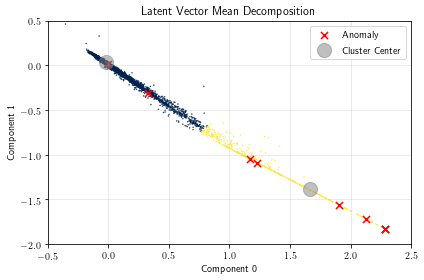

In [601]:
plt.scatter(test_encoded.mean()[:, 0], test_encoded.mean()[:, 1], s=0.2, c=kmeans.predict(test_encoded.mean()), cmap='cividis')
plt.scatter(annomaly_encoded.mean()[:, 0], annomaly_encoded.mean()[:, 1], s=50.0, color='red', marker='x', label='Anomaly')

plt.xlim(-0.5, 2.5)
plt.ylim(-2, 0.5)

plt.title('Latent Vector Mean Decomposition')
plt.xlabel('Component 0')
plt.ylabel('Component 1')

plt.scatter([-0.02175249, 1.66804396], [0.03367793, -1.38568922], s=200, alpha=0.5, color='gray', label='Cluster Center')

plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('decomposition.png', bbox_inches='tight')
plt.show()